# Libraries

In [1]:
import numpy as np
import pandas as pd
import math
import codecs
import spacy
import json

# Load Data

# Parsing

In [2]:
import markdown

# with open('Manovich.md', 'r') as f: text = f.read()
# texts = text.split("\n# ")[2:] # Split and remove the first two elements

with open('PAP.md', 'r') as f: text = f.read()
texts = text.split("\n") # Split and remove the first two elements


len(texts)

56

In [4]:
import textacy
import textacy.tm
import textacy.preprocessing

en = textacy.load_spacy_lang("en_core_web_sm", disable=("parser",))
# en = textacy.load_spacy_lang("en_core_web_lg", disable=("parser",))
# en = textacy.load_spacy_lang("en_core_web_trf", disable=("parser",))

docs = []
titles = [] # List of titles

for index, text in enumerate(texts):
    titles.append(text.split('\n\n')[0])
    docs.append(textacy.make_spacy_doc(text, lang=en))
    print(index, end=' ')
    # print(doc._.preview)
    

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 

# Lematization

In [96]:
from functools import partial

stopwords = {'pap'}

lemmas = []

ngs = partial(textacy.extract.ngrams, n=[1], include_pos={'NOUN'})
# ngs = partial(textacy.extract.ngrams, n=[1, 2], include_pos={'ADJ', 'NOUN'})
# ngs = partial(textacy.extract.ngrams, n=[1], include_pos={"NOUN"})
# ents = partial(textacy.extract.entities, include_types={"PERSON", "ORG", "GPE", "LOC"})

for doc in docs:
    # extraction = textacy.extract.keyterms.textrank(doc, normalize='lemma')
    extraction = textacy.extract.terms(doc, ngs=ngs)
    # extraction = textacy.extract.basics.words(doc, filter_stops=True, filter_nums=True)
    lemmatization = textacy.extract.terms_to_strings(extraction, by="lemma")
    
     # Remove strings containing stopwords
    lemmatization = [l for l in lemmatization if not any(stopword in l for stopword in stopwords)]
    lemmatization = [l for l in lemmatization if not '||||' in l]
    
    for index, l in enumerate(lemmatization):
        if 'datum' in l : lemmatization[index] = l.replace('datum', 'data')
        if 'medium' in l : lemmatization[index] = l.replace('medium', 'media')
        
    lemmas.append(list(lemmatization))

# TF-IDF

doc_term_matrix, dictionary = textacy.representations.build_doc_term_matrix(lemmas, tf_type="linear", idf_type="smooth")

doc_term_matrix


<56x479 sparse matrix of type '<class 'numpy.float64'>'
	with 992 stored elements in Compressed Sparse Row format>

# UMAP

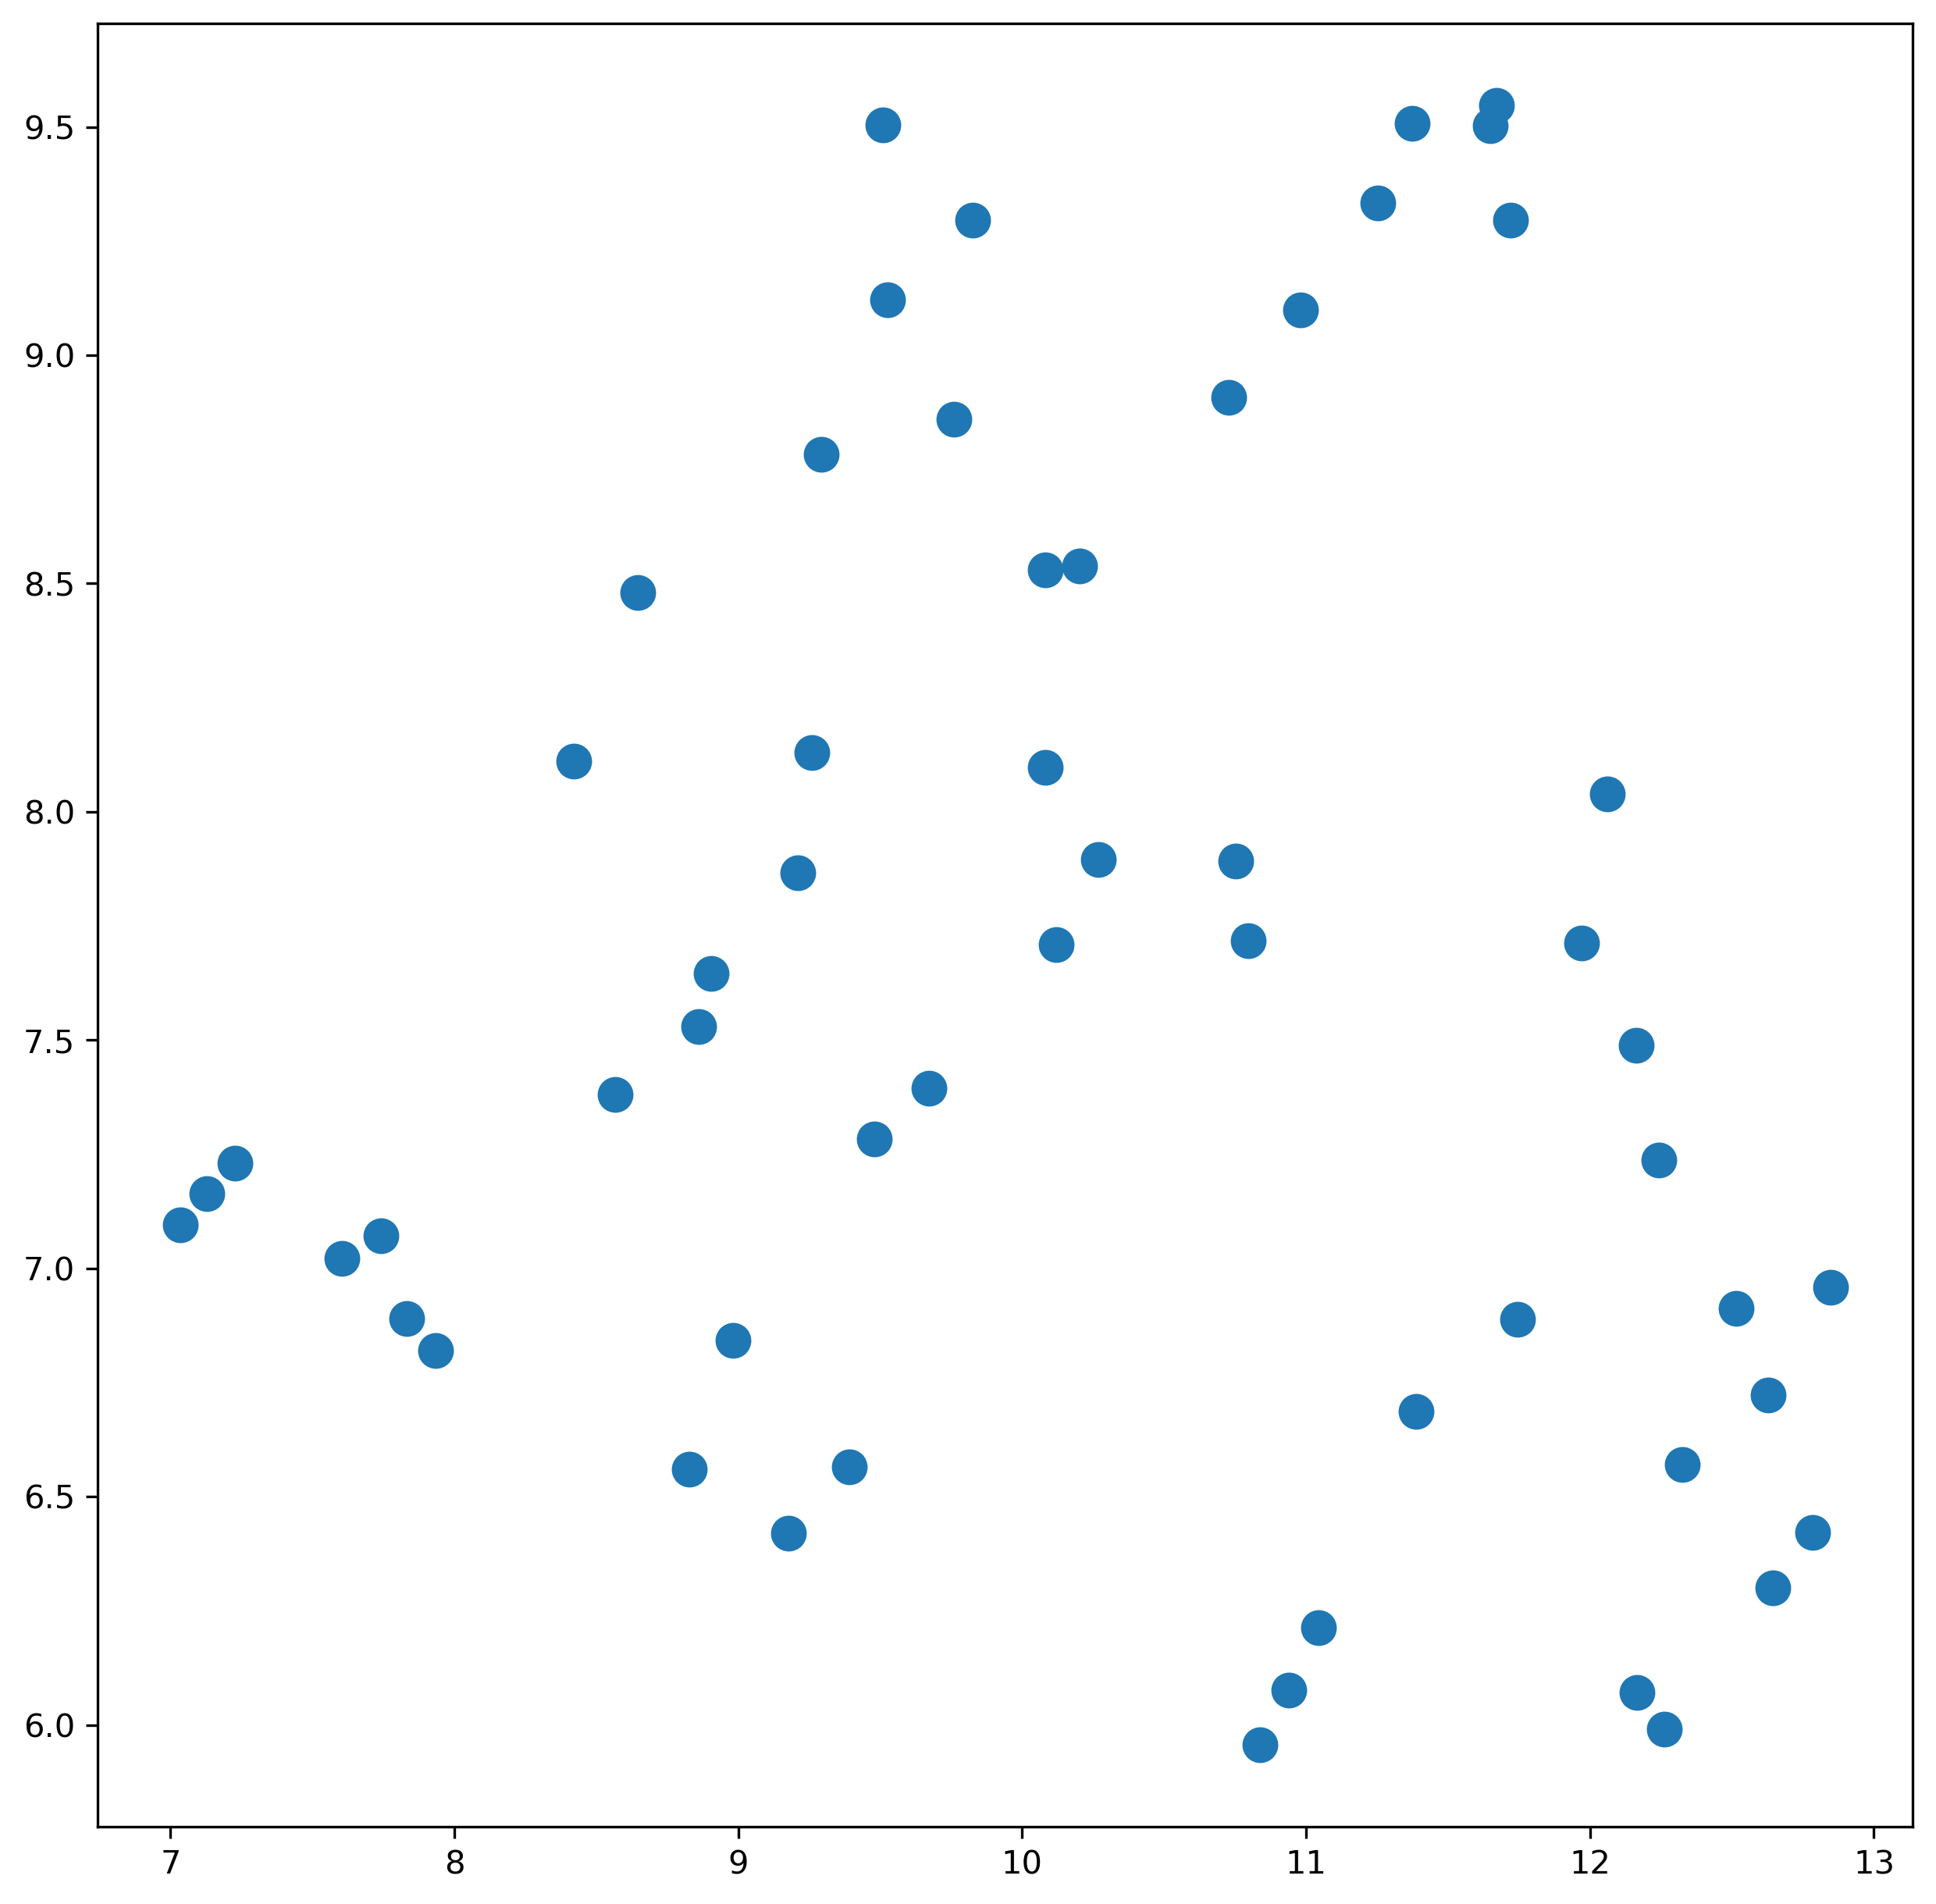

In [122]:
# import umap
import umap.umap_ as umap
import matplotlib.pyplot as plt
from pointgrid import align_points_to_grid

# reducer = umap.UMAP(random_state=2, n_components=2, n_neighbors=8, min_dist=0.01, metric='cosine')
reducer = umap.UMAP(random_state=2, n_components=2, n_neighbors=6, min_dist=0.01, metric='hellinger')

embedding = reducer.fit_transform(doc_term_matrix)
# embedding = align_points_to_grid(embedding)

x = embedding[:, 0]; y = embedding[:, 1]

plt.figure(figsize=(10,10), dpi=300)
plt.scatter(x, y, s=100)
# plt.scatter(x, y, s=100, c=topics)

# for i, title in enumerate(titles):
#     text = plt.annotate(title, (x[i], y[i]))
#     text.set_fontsize(5)

plt.show()


    

# Lemmas Pairing

In [123]:
pairs = []

i = 0

while len(pairs) == 0:
    i += .05
    
    for indexA, a in enumerate(embedding):
        for indexB, b in enumerate(embedding):
            if indexB > indexA:
                distance = dist = math.sqrt((b[0] - a[0])**2 + (b[1] - a[1])**2)
                if 0 < distance and distance < i:
                    x = (b[0] + a[0]) / 2
                    y = (b[1] + a[1]) / 2
                    
                    intersection = list(set(lemmas[indexA]) & set(lemmas[indexB]))

                    wordfreq = []
                    for lemma in intersection:
                        wordfreq.append([lemma, lemmas[indexA].count(lemma) + lemmas[indexA].count(lemma)])
                    
                    wordfreq.sort(key=lambda x:x[1])
                    wordfreq.reverse()

                    pairs.append([x,y, [i[0] for i in wordfreq[:3]] ])


print(len(pairs), 'lexical pairs')
pairs[0]


1 lexical pairs


[11.659605026245117, 9.525211334228516, ['number', 'formula', 'end']]

# Cluster Identification

In [133]:
import hdbscan

# clusterer = hdbscan.HDBSCAN(min_cluster_size=4, min_samples=3, cluster_selection_epsilon=.2)
# clusterer = hdbscan.HDBSCAN(min_cluster_size=5)
clusterer = hdbscan.HDBSCAN(min_cluster_size=4, cluster_selection_method='leaf')
# min_samples is to consier all the elements that owtherwide will be classified as noise
# cluster_selection_epsilon extends clusters
clusterer.fit(embedding)
clusters = clusterer.labels_

# Grouping by cluster

values = set(clusters)
if -1 in values: values.remove(-1)

clusters = [[index for index, cluster in enumerate(clusters) if cluster==value] for value in values]

len(clusters)

3

# Save Files

In [134]:
json.dump(embedding.tolist(), codecs.open('../src/data/embedding.json', 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=False, indent=4)
# json.dump(authors, codecs.open('../src/data/authors.json', 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=False, indent=4)
json.dump(lemmas, codecs.open('../src/data/lemmas.json', 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=False, indent=4)
json.dump(pairs, codecs.open('../src/data/pairs.json', 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=False, indent=4)
# json.dump(topics, codecs.open('../src/data/topics.json', 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=False, indent=4)
json.dump(clusters, codecs.open('../src/data/clusters.json', 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=False, indent=4)

# Word Clouds

In [135]:
from wordcloud import WordCloud, get_single_color_func
from PIL import Image, ImageDraw

# from planar import Polygon # It's not working anymore

from os import path
import multidict as multidict

from scipy.spatial import ConvexHull
from scipy import interpolate


for index, cluster in enumerate(clusters):

    scale = 300
    
    min_X = int(min([i[0] for i in embedding[cluster]]) * scale)
    max_X = int(max([i[0] for i in embedding[cluster]]) * scale)
    min_Y = int(min([i[1] for i in embedding[cluster]]) * scale)
    max_Y = int(max([i[1] for i in embedding[cluster]]) * scale)

    width = max_X - min_X; height = max_Y - min_Y
    
    points = list(map(lambda i: (int(i[0] * scale - min_X), int(i[1] * scale - min_Y)), embedding[cluster]))

    # Hull

    hull = ConvexHull(points)

    x_hull = np.append(hull.points[hull.vertices,0], hull.points[hull.vertices,0][0])
    y_hull = np.append(hull.points[hull.vertices,1], hull.points[hull.vertices,1][0])
    
    # Interpolation
    
    dist = np.sqrt((x_hull[:-1] - x_hull[1:])**2 + (y_hull[:-1] - y_hull[1:])**2)
    dist_along = np.concatenate(([0], dist.cumsum()))
    spline, u = interpolate.splprep([x_hull, y_hull], u=dist_along, s=0)
    interp_d = np.linspace(dist_along[0], dist_along[-1], 50)
    interp_x, interp_y = interpolate.splev(interp_d, spline)    
    interp_points = list(zip(interp_x, interp_y))

    # Create mask

    img = Image.new(mode = "RGBA", size = (width, height), color = (255, 255, 255))
    draw = ImageDraw.Draw(img)
    # draw.polygon(points, fill=(0,0,0))
    draw.polygon(interp_points, fill=(0,0,0))
    mask = np.array(img)


    # Collect text

    text = []
    for id in cluster:
        text = text + lemmas[id]
    text = ' '.join(map(str, text))
    # text = text.replace('datum', 'data')
    # text = text.replace('medium', 'media')

    dictionary = multidict.MultiDict()
    _dictionary = {}


    # Frequency

    for _word in text.split(" "):
        val = _dictionary.get(_word, 0)
        _dictionary[_word] = val + 1
    for key in _dictionary:
        dictionary.add(key, _dictionary[key])


    # Wordcloud

    max_words = math.ceil(len(dictionary)*.01)


    wc = WordCloud(
        mode = "RGBA",
        color_func=lambda *args, **kwargs: (0, 0, 0),
        font_path = path.join('Lato-Regular.ttf'),
        mask=mask,
        
        normalize_plurals=False,
        prefer_horizontal= 1,
        
        margin=40,

        background_color=None,
        # background_color='black',

        # max_words=max_words,
        
        min_font_size= 10,
        max_font_size= 100,
        # collocation_threshold = 20,
        relative_scaling = 0,
    )

    print(index, max_words, '-', end=' ')
    
    wc.generate_from_frequencies(dictionary) # generate word cloud
    wc.to_file(path.join("../src/wordclouds/" + f"{index:02}" + ".png")) # store to file

    

0 2 - 1 1 - 2 3 - 